# Model Validation

## References 

[1] [Information Theoretic Model Selection for Pattern Analysis](https://proceedings.mlr.press/v27/buhmann12a/buhmann12a.pdf)

[2] [Approximated sorting](https://link.springer.com/content/pdf/10.1007%2F978-3-642-40602-7_15.pdf)

In [ ]:
import numpy as np
import numpy
import matplotlib.pylab as plt
import time

import sklearn as skl
from functools import reduce

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.linalg as linalg
import scipy.stats as ss

# Make sure to install treelib in the slt-ce conda environment: conda install treelib
import treelib as tl

from sklearn.utils.validation import check_is_fitted
import sklearn.model_selection as model_selection
import sklearn.cluster as cluster
import sklearn.metrics as metrics

import sklearn.manifold as man

<p style="background-color:#adebad;">
Main idea behind the Model Validation:   
</p>

Weighted Approximation Set Coding (wASC) takes two sample sets $\mathbf X^{(1)}$ and $\mathbf X^{(2)}$ with the same inherent structure but different noise realizations. When optimizing a cost function on these data sets (learning) their global minima will typically be different (instability of solutions). Therefore, wASC introduces approximation weights to tackle this problem. Non-optimal solutions with large approximation weights $w_\beta(c,\mathbf X)\ge1-\varepsilon, \varepsilon \ll 1$ can be accepted as substitutes of the global minimizers. Therefore the inverse computational tenperature $\beta$ must be chosen suitably based on the noise level that is inherent in the data.

In a learning-theoretic sense, the set of solutions with large weights generalizes significantly better than the set of global minimizers, provided that $\beta$ is suitably chosen. wASC is a concept developed to determine such an appropriate scale $\beta$. The two data sets $\mathbf X^{(q)},q\in\{ 1,2 \}$ define two weight sets $w_\beta (c,\mathbf X^{(q)})$. These weights give rise to the two weight sums $\mathcal Z_q$ and the joint weight sum $\mathcal Z_{12}$:

\begin{equation}
\mathcal Z_q := \mathcal Z(\mathbf X^{(q)}) = \sum_{c \in \mathcal C(\mathbf X^{(q)})} \exp \left( -\beta \Delta R(c,\mathbf X^{(q)}) \right), \quad q=1,2
\end{equation}
\begin{equation}
\mathcal Z_{12} := \mathcal Z(\mathbf X^{(1)},\mathbf X^{(2)}) = \sum_{c \in \mathcal C(\mathbf X^{(2)})} \exp \left( -\beta \left( \Delta R(c,\mathbf X^{(1)}) + \Delta R(c,\mathbf X^{(2)}) \right) \right)
\end{equation}

where the combined weight sum quantifies how well the solution $c$ minimizes costs on both datasets. $\mathcal Z_q$ is the number of statistically indistinguishable data patterns that approximate the minimum of the objective function. While the global optimum $c^\perp(\mathbf X)$ can change whenever another random subset of the data is taken, the set of weights $\{w_\beta(c,\mathbf X)\}$ remains approximately invariant for a well-tuned $\beta$. Now the question is how one should choose such a $\beta$ so that  identifiability of $\{ w_\beta : w_\beta (c,\mathbf X) \ge 1 - \varepsilon \}$ is ensure in the presence of data fluctuations.


Based on a hypothetical communication scenario, [1] derive the optimal $\beta$ as the maximizer of the mutual information $\mathcal I_\beta(\tau_s\hat \tau)$. This result is derived from the error analysis of the coding protocol for the proposed communication scenario.


With two data sets $\mathbf X^{(1)}$ and $\mathbf X^{(2)}$ drawn from the same source, the cost function of a parametric clustering model with $K$ clusters reads

\begin{equation}
R(c,\mathbf X)=\sum_{i=1}^n \varepsilon_{i,c(i)} \quad \mathrm{with} \quad \forall i, c(i) \in \{ 1,...,K \},
\end{equation}

where $\varepsilon_{i,c(i)}$ indicates the cost of assigning object $i$ to cluster $c(i)$. For k-means we have $\varepsilon_{i,c(i)}=\| x_i - y_{c(i)} \|^2$. Hence, the mutual information $\mathcal I_\beta(\tau_s\hat \tau)$ for clustering is given by

\begin{equation}
\mathcal I_{\beta} 
= \frac{1}{n} \log |\{ \tau_s \} 
+ \frac{1}{n} \sum_{i=1}^N 
\left( 
\log \sum_{k=1}^K e^{-\beta \left( \varepsilon_{i,k}^{(1)} + \varepsilon_{i,k}^{(2)} \right) } - \log \sum_{k=1}^N e ^{-\beta \varepsilon_{i,k}^{(1)}} \sum_{k'=1}^K e^{-\beta \varepsilon_{i,k'}^{(2)} }.
\right)
\end{equation}

Eventually, the approximation capacity (mutual information of the best model, i.e. the solution of the model selection problem) is numerically determined as the maximum of $\mathcal I_{\beta}$ over $\beta$. 

In general, the procedure is as follows: 
- Randomly split the given data set into two subsets $\mathbf X^{(1)}$ and $\mathbf X^{(1)}$ 
- Compute the mutual information for each candidate cost function $R(c,\mathbf X) \in \mathcal R$ and maximize it with respect to $\beta$ 
- Select the cost function that achieves the highest capacity at the best resilution $\beta^\star$ 

For the special case of model selection for clustering we have:
- Compute the cardinality $| \{ \tau_s \} |$ of the set of possible transformations $\tau_s$ (hypothesis space). This is the space of all possible assignments of objects to sources - i.e. the permutation of objects. $| \{ \tau_s \} |$ is the number of all distinct clusterings on $\mathbf X^{(1)}$
- Calculate the induvidual and joint weight sums $\mathcal Z_1$, $\mathcal Z_2$ and $\mathcal Z_{12}$
- Maximize $\mathcal I_\beta$ with respect to $\beta$



<p style="background-color:#adebad;">
We use the following data source:

$$p(\textbf{x})=\frac{1}{2}\mathcal{N}(\textbf{x} | \textbf{0}, \sigma_1^2\mathbb{I}) + 
\frac{1}{2}\mathcal{N}(\textbf{x} | r\textbf{v},\sigma_2^2\mathbb{I}) $$

<p style="background-color:#adebad;">
with $\mathbf{x}, \mathbf{v} \in \mathbb{R}^d$, $\lVert \mathbf{v} \rVert=1$ and $r\in\mathbb{R}_+$.
The following function generates data from this distribution:
</p>

In [2]:
def generate_data(var_1, var_2, r, v, num_samples, plot_hist=False):
    """Generate data from the described model using provided parameters:
    Args:
            var_1 (number): varience of the first cluster
            var_2 (number): varience of the second cluster
            r (number): distance r to the center of the second cluster
            v (np.ndarray): direction v of the center of the second cluster
            num_samples (number): number of points to be generated
    
    Returns:
            data (np.ndarray): generated points
            labels (np.ndarray): true cluster assigment for the generated points 
    """    
    
    # Set-up
    n_dim = v.size
    n_components = 2
    numpy.random.seed(0x5eed)
    
    # Parameters of the mixture components
    cov = np.zeros((n_dim,n_dim,n_components))
    cov[:,:,0] = var_1 * np.identity(n_dim)
    cov[:,:,1] = var_2 * np.identity(n_dim)
    mean = np.zeros((n_dim,n_components))
    mean[:,0] = np.zeros(n_dim)
    mean[:,1] = r * v

    # Weight of each component, in this case all of them are 1/3
    weights = np.ones(num_components, dtype=np.float64) / float(num_components)

    # A stream of indices from which to choose the component
    labels = numpy.random.choice(num_components, size=num_samples, replace=True, p=weights)

    # Y is the multivariate mixture sample
    data = np.zeros((n_dim,len(labels)))
    counter = 0
    for i in labels:
        data[:,counter] = np.random.multivariate_normal(mean[:,i],cov[:,:,i],1)
        counter += 1

    # Plot histogram per dimension    
    if plot_hist:
        for i in range(v.size):    
            y = data[i,:]
            # Theoretical PDF plotting - generate the x and y plotting positions
            xs = np.linspace(y.min(), y.max(), 200)
            ys = np.zeros_like(xs)
            # Theoretical distribution
            for j in range(num_components):
                ys += ss.norm.pdf(xs, loc=mean[i,j], scale=np.sqrt(cov[i,i,j])) * weights[j]
            plt.plot(xs, ys)
            plt.hist(y, normed=True, bins="fd")
            plt.xlabel("x_{}".format(i))
            plt.ylabel("f(x)")
            plt.show()        
        
    return data, labels    


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


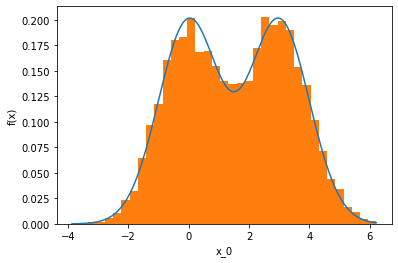

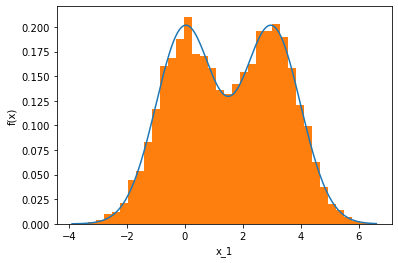

In [5]:
# Test data generation

var_1 = 1
var_2 = 1
r = 3
v = np.array([1,1])
num_samples = 10000    
num_components = 2
plot_hist = True
data, labels = generate_data(var_1, var_2, r, v, num_samples, plot_hist)


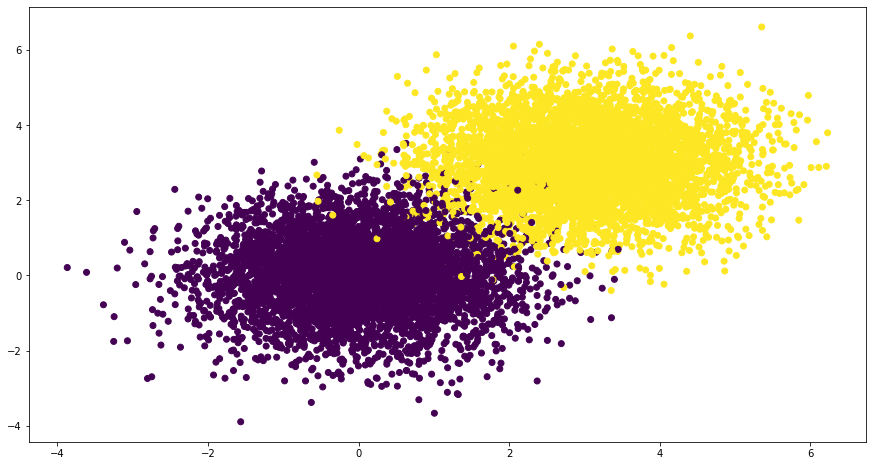

In [6]:
# Generate and plot 2D points for different combinations of  σ1 ,  σ2  and  r. 
# Colors indicate the cluster assigment.

plt.figure(figsize=(15,8))
colors = labels #+ 1
plt.scatter(data[0],data[1],c = colors)
plt.show()


<p style="background-color:#adebad;">
In order to reproduce the results described in the reference paper [1], section 4.1, we need to calculate mutual information of two clusterings. See section 3 in [1] for more details.
</p>

In [41]:
def mutual_information(X_1, X_2, y_1, y_2, t):
    """Compute mutual information of two clusterings
    Args:
        x_1 (np.ndarray): first dataset
        x_2 (np.ndarray): second dataset
        y_1 (np.ndarray): cluster centers for the first dataset
        y_2 (np.ndarray): cluster centers for the second dataset
        t (float): temperature T
    Returns:
        mutual_information (float): mutual information of x_1 and x_2
    """
    
    N_1 = X_1.shape[1]
    N_2 = X_2.shape[1]
    K_1 = y_1.shape[1]
    K_2 = y_2.shape[1]
    eps_1 = np.zeros((N_1,K_1))
    eps_2 = np.zeros((N_1,K_1))
    
    beta = 1/t
    card_tau_s = float(N_1**K_1)
        
    # Compute the cost matrices
    for i in range(N_1):
        for k in range(K_1):
            eps_1[i,k] = np.linalg.norm(X_1[:,i] - y_1[:,k])**2
            
    for i in range(N_2):
        for k in range(K_2):
            eps_2[i,k] = np.linalg.norm(X_2[:,i] - y_2[:,k])**2
                
    sum_data_logs = 0
    for i in range(N_1): # N_1 = N_2
        sum_cluster_exp_data12_i = 0
        sum_cluster_exp_data1_i = 0
        sum_cluster_exp_data2_i = 0
        for k in range(K_1): # K_1 = K_2
            sum_cluster_exp_data12_i += np.exp(-beta*(eps_1[i,k]+eps_2[i,k]))
            sum_cluster_exp_data1_i += np.exp(-beta*eps_1[i,k])
            sum_cluster_exp_data2_i += np.exp(-beta*eps_2[i,k])
        sum_data_logs += np.log2(sum_cluster_exp_data12_i) - np.log2(sum_cluster_exp_data1_i * sum_cluster_exp_data2_i)

    I_beta = np.log2(card_tau_s)/N_1
    I_beta += 1/N_1 * sum_data_logs
    
    return I_beta

In [238]:
# Test of mutual information implementation (with two identical data sets) 

var_1 = 1
var_2 = 1
r = 1
v = np.array([1, 1])
n_samples = 100
data, labels = generate_data(var_1, var_2, r, v, n_samples, False)
centers = np.array([[0, 0], [r, r]])

MI = mutual_information(data, data, centers, centers, 1)
print(MI)


3.0995036748662224
9.210340371976184
-69.31471805599465
-0.6010437768401846


<p style="background-color:#adebad;">
We implement an extended Deterministic Annealing class from notebook 2 in this folder so that it logs the MI score for every evaluated temperature T. Note that the mutual information score is defined for a hard assignment while deterministic annealing results in a probabilistic one.
</p>

In [21]:
class DeterministicAnnealingClustering(skl.base.BaseEstimator, skl.base.TransformerMixin):
    """Template class for DAC
    
    Attributes:
        cluster_centers_ (np.ndarray): Cluster centroids y_i (n_clusters, n_features)
        cluster_probabs_ (np.ndarray): Assignment probability vectors p(y_i | x) for each sample
                                       (n_samples, n_clusters)
        bifurcation_tree_ (treelib.Tree): Tree object that contains information about cluster evolution during
                                          annealing.
                                       
    Parameters:
        n_clusters (int): Maximum number of clusters returned by DAC.
        random_state (int): Random seed.
    """
    
    def __init__(self, n_clusters=8, random_state=42, metric="euclidian", record = True):
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.metric = metric
        # Add more parameters, if necessary.
        self.record = record
        self.bifurcation_tree_ = tl.Tree()
        self.cluster_history = []
        self.eff_clusters = [1]
        self.expected_distortions = []
        self.temperatures = []
            
    def fit(self, X):
        """Compute DAC for input vectors X
        
        Preferred implementation of DAC as described in reference [1].
        Consider to use initialization and reseeding as in sklearn k-means for improved performance.
        
         Args:
            X (np.ndarray): Input array with shape (samples, n_features)
        
        Returns:
            self
        """
        #Initialization
        np.random.seed(self.random_state)
        rate = 0.95 #0.95 #alpha
        iterations = 130#100
        temp_sum = np.zeros((len(X[0]),len(X[0])))
        centroids = [(np.sum(X,axis=0)/len(X)).T]
        for j in range(len(X)): #Initial covariance matrix
            tc = np.reshape(X[j] - centroids[0],(-1,1)) @ np.reshape(X[j] - centroids[0],(1,-1))
            temp_sum += tc
        C = temp_sum/(len(X))
        eigen_value = linalg.eigvalsh(C, eigvals=(len(X[0])-1,len(X[0])-1))[0]
        T = eigen_value*3 #Start temperature, 3 > 2
        self.temperatures.append(T)
        t_min = T*(rate**iterations)
        K = 1
        probs = [1]
        self.cluster_history.append(centroids[0])
        self.bifurcation_tree_.create_node(tag = ".0", data = [[centroids[0]],[0],"+"], identifier = ".0")
        parent = [""]
        if self.metric == "euclidian":
            e_distort = [np.dot(X[row]-centroids[0],X[row]-centroids[0]) for row in range(len(X))]
            self.expected_distortions.append(np.sum(e_distort)/len(X))
            while T > t_min:
                probscop = probs.copy()
                squares = np.zeros((len(X),K))
                for w in range(len(X)):
                        for j in range(K):
                            squares[w][j] = np.dot(X[w]-centroids[j],X[w]-centroids[j])
                for i in range(K):
                    pyx = np.zeros(len(X))
                    for j in range(len(X)):
                        b = np.min(squares[j])/T # Shift to ensure no overflow
                        temp = probscop[i]*np.exp(-(squares[j][i]/T)+b) # enumrator of p(y|X_i)
                        Z = np.dot(probscop, np.exp(-squares[j]/T + b)) # Denominator
                        pyx[j] = temp/Z # P(y|x)
                    probs[i] = np.sum(pyx)/len(X)
                    temp_sum = np.matmul(pyx,X) # sum over x*p(y|x)
                    centroids[i] = temp_sum/(probs[i]*len(X)) # multiply by p(x) = 1/n
                T *= rate
                if K < self.n_clusters:
                    new_cs = 0 # New clusters added at this temperature
                    squares = np.zeros((len(X),K))
                    zx = np.zeros(len(X)) # Denominator of P(y|x_i) for each x_i
                    for r in range(len(X)):
                        for j in range(K):
                            squares[r][j] = np.dot(X[r]-centroids[j],X[r]-centroids[j])
                        b = np.min(squares[r])/T
                        zx[r] = np.dot(probs,np.exp(-squares[r]/T+b))
                    for i in range(K):
                        temp_sum = np.zeros((len(centroids[0]),len(centroids[0])))
                        for j in range(len(X)):
                            b = np.min(squares[j])/T
                            tc = np.reshape(X[j] - centroids[i],(-1,1)) @ np.reshape(X[j] - centroids[i],(1,-1))
                            expo = np.exp((-squares[j][i]/T)+b)
                            temp_sum += (expo/zx[j])*tc
                        C = probs[i]*temp_sum/(len(X))
                        eigen_value = linalg.eigvalsh(C, eigvals=(len(X[0])-1,len(X[0])-1))[0]
                        if T <= 2*eigen_value and K + new_cs < self.n_clusters:
                            centroids.append(centroids[i] + np.random.normal(0,0.001,size=(len(X[0]))))
                            probs[i] /= 2
                            probs.append(probs[i])
                            new_cs += 1
                            if self.record:
                                parent.append(parent[i] + "." + str(i))
                                parent[i] += "." + str(i)
                                self.bifurcation_tree_.create_node(tag = parent[i] + "." + str(i),
                                                                data = [[],[],"+"],
                                                                identifier = (parent[i] + "." + str(i)), 
                                                                parent = parent[i])
                                self.bifurcation_tree_.create_node(tag = parent[i] + "." + str(len(centroids)-1),
                                                               data = [[],[],"-"], 
                                                               identifier = (parent[i]  + "." + str(len(centroids)-1)), 
                                                               parent = parent[i])
                    K += new_cs
                
                if self.record:
                    for node in range(K):
                        current_node = self.bifurcation_tree_.get_node(parent[node] + "." + str(node))
                        current_node.data[0].append(centroids[node])
                        if current_node.identifier == ".0":
                            current_node.data[1].append(0)
                        else:
                            node_parent = self.bifurcation_tree_.get_node(parent[node])
                            current_node.data[1].append(np.sqrt(np.dot(centroids[node]-node_parent.data[0][-1],centroids[node]-node_parent.data[0][-1])))

                    self.cluster_history.append(centroids.copy())
                    self.eff_clusters.append(K)

                    e_distort = 0
                    squares = np.zeros((len(X),K))
                    for i in range(len(X)):
                        for j in range(K):
                            squares[i][j] = np.dot(X[i]-centroids[j],X[i]-centroids[j])
                    for row in range(len(X)):
                        temp = []
                        dist = []
                        b = np.min(squares[row])/T
                        for col in range(K):
                            square = squares[row][col]
                            temp.append(probs[col]*np.exp(-square/T+b)/np.dot(probs,np.exp(-squares[row]/T + b)))
                            dist.append(square)
                        e_distort += np.dot(dist,temp)
                    e_distort /= len(X)
                    self.expected_distortions.append(e_distort)
                    self.temperatures.append(T)
                    
            # T = 0 STEP
            
            squares = np.zeros((len(X),K))
            for i in range(len(X)):
                for j in range(K):
                    squares[i][j] = np.dot(X[i]-centroids[j],X[i]-centroids[j])
            closest_cluster = np.zeros(len(X))
            for row in range(len(squares)):
                closest_cluster[row] = np.argmin(squares[row])
            temp_clusters = np.zeros((K,len(X[0])))
            count_y = np.zeros(K)
            for closest in range(len(closest_cluster)):
                temp_clusters[int(closest_cluster[closest])] += X[closest]
                count_y[int(closest_cluster[closest])] += 1
            for cluster in range(K):
                temp_clusters[cluster] /= count_y[cluster]
            
            centroids = temp_clusters
                
        elif self.metric == "ratioscale":
            def distance(x,y):
                n = len(x)
                temp_sum = 0
                for i in range(n):
                    for j in range(n):
                        temp_sum += (x[i]*y[j])/(x[j]*y[i])
                return temp_sum/(n**2)
            
            def gradient(x,y):
                enumerator = np.zeros(len(x))
                denominator = 0
                for i in range(len(x)):
                        for j in range(len(x)):
                            denominator += x[i]*y[j]/(x[j]*y[i])
                for k in range(len(x)):
                    summand_1 = 0
                    summand_2 = 0
                    for i in range(len(x)):
                        if i != k:
                            qoutient = (x[i]/y[i])
                            summand_1 += qoutient
                            summand_2 += (1/qoutient)
                    enumerator[k] = (1/x[k])*summand_1 - (x[k]/(y[k]**2))*summand_2
                return enumerator/denominator
            while T > t_min:
                probscop = probs.copy()
                pyx = np.zeros((len(X),K))
                z = np.zeros(len(X))
                for row in range(len(X)):
                    for j in range(K):
                        pyx[row][j] = (distance(X[row],centroids[j])**(-1/T))
                    z[row] = np.sum(pyx[row])
                for i in range(K):
                    probs[i] = sum([pyx[row][i]/z[row] for row in range(len(X))])/len(X)
                    echelons = 30
                    learning_rate = 0.02
                    #Gradient Descent
                    for iteration in range(echelons):
                        grad = np.zeros(len(X[0]))
                        samp = np.random.choice(len(X), 125, replace=False)
                        for j in samp:
                            grad += (pyx[j][i]/z[j])*gradient(X[j],centroids[i])
                        centroids[i] -= learning_rate*grad/len(X)
                        learning_rate *= 0.975
                        for element in range(len(X[0])):
                            if centroids[i][element] <= 0:
                                centroids[i][element] = 0.00000001
                        for row in samp:
                            pyx[row][i] = (distance(X[row],centroids[i])**(-1/T))
                            z[row] = np.sum(pyx[row])
                        probs[i] = sum([pyx[r][i]/z[r] for r in range(len(X))])/len(X)
                if K < self.n_clusters:
                    new_cs = 0 #New clusters added at this temperature
                    pyx = np.zeros((len(X),K))
                    for row in range(len(X)):
                        for j in range(K):
                            pyx[row][j] = ((distance(X[row],centroids[j])**(-1/T)))
                        pyx[row] /= np.sum(pyx[row])
                    for i in range(K):
                        temp_sum = np.zeros((len(centroids[0]),len(centroids[0])))
                        for j in range(len(X)):
                            tc = np.reshape(X[j] - centroids[i],(-1,1)) @ np.reshape(X[j] - centroids[i],(1,-1))
                            temp_sum += pyx[j][i]*tc
                        C = temp_sum/(probs[i]*len(X))
                        eigen_value = linalg.eigvalsh(C, eigvals=(len(X[0])-1,len(X[0])-1))[-1]
                        if T <= 2*eigen_value and K + new_cs < self.n_clusters:
                            centroids.append(centroids[i] + np.abs(np.random.normal(0,1,size=(len(X[0])))))
                            probs[i] /= 2
                            probs.append(probs[i])
                            new_cs += 1
                    K += new_cs
                self.cluster_history.append(centroids.copy())
                self.eff_clusters.append(K)
                
                e_distort = 0
                
                for row in range(len(X)):
                    temp = []
                    dist = []
                    for col in range(K):
                        square = distance(X[row],centroids[col])
                        temp.append(square**(-1/T))
                        dist.append(np.log(square))
                    e_distort += (np.dot(dist,temp)/sum(temp))
                e_distort /= len(X)
                self.expected_distortions.append(e_distort)
                self.temperatures.append(T)
                T *= rate
            pyx = np.zeros((len(X),K))
            for row in range(len(X)):
                mini = 100000000
                classi = ""
                for i in range(K):
                    disti = distance(X[row], centroids[i])
                    if disti < mini:
                        mini = disti
                        classi = i
                pyx[row][classi] += 1
            for i in range(K):
                probs[i] = sum([pyx[row][i] for row in range(len(X))])/len(X)
                echelons = 40
                learning_rate = 0.02
                #Gradient Descent
                for iteration in range(echelons):
                    grad = np.zeros(len(X[0]))
                    #samp = np.random.choice(len(X), 75, replace=False)
                    for j in range(len(X)):
                        grad += pyx[j][i]*gradient(X[j],centroids[i])
                    centroids[i] -= learning_rate*grad/len(X)
                    learning_rate *= 0.975
                
            # code for extension
        if not(self.record):
            self.eff_clusters.append(K)
        self.cluster_centers_ = centroids
        self.T_min = T
        return self
    
    def predict(self, X):
        """Predict assignment probability vectors for each sample in X.
        
        Args:
            X (np.ndarray): Input array with shape (new_samples, n_features)
            
        Returns:
            P (np.ndarray): Assignment probability vectors (new_samples, n_clusters) 
        """
        probs = []
        for row in range(len(X)):
            temp = np.zeros(self.eff_clusters[-1])
            for j in range(self.eff_clusters[-1]):
                temp[j] = np.exp(-np.sqrt(np.dot(X[row] - self.cluster_centers_[j],X[row] - self.cluster_centers_[j]))/self.T_min)
            probs.append(temp/sum(temp))
        
        P = np.array(probs)
        
        return P
    
    def transform(self, X):
        """Transform X to a cluster-distance space.
        
        In the new space, each dimension is the distance to the cluster centers. 
        
        Args:
            X (np.ndarray): Input array with shape (new_samples, n_features)
            
        Returns:
            Y (np.ndarray): Cluster-distance vectors (new_samples, n_clusters)
        """
        check_is_fitted(self, ["cluster_centers_"])
        Y = np.zeros((len(X),self.eff_clusters[-1]))
        def distance(x,y):
            n = len(x)
            temp_sum = 0
            for i in range(n):
                for j in range(n):
                    temp_sum += (x[i]*y[j])/(x[j]*y[i])
            return np.log((1/(n**2)*temp_sum))
        for row in range(len(X)):
            for j in range(self.eff_clusters[-1]):
                if self.metric == "euclidian":
                    Y[row][j] = np.sqrt(np.dot(X[row]-self.cluster_centers_[j],X[row]-self.cluster_centers_[j]))
                elif self.metric == "ratioscale":
                    Y[row][j] = distance(X[row],self.cluster_centers_[j])
                
        
        return Y
    
    def plot_bifurcation(self):
        """Show the evolution of cluster splitting"""
        check_is_fitted(self, ["bifurcation_tree_"])
        
        paths = self.bifurcation_tree_.paths_to_leaves()
        dists = []
        y_axis = [np.log(self.temperatures[0]/self.temperatures[i]) for i in range(len(self.temperatures))]
        used = set()
        for path in paths:
            temp = []
            for node in path:
                current_node = self.bifurcation_tree_.get_node(node)
                new_distances = current_node.data[1]
                if len(temp) > 0:
                    if current_node.data[2] == "+":
                        temp.extend([temp[-1] + di for di in new_distances])
                    else:
                        temp.extend([temp[-1] - di for di in new_distances])
                else:
                    temp.extend(new_distances)
            dists.append(temp)
        plt.figure()
        for di in dists:
            plt.plot(di,y_axis)
        
        return None

def postprocess(y_DAC, y_kmeans):
    """
    Calculates the most likely cluster assignement of DAC
    
    Transform the cluster label to match kmeans cluster labeling.
    
    The method is needed, so one can compare kmeans with DAC using the same labeling of the clusters.
    Args:
        y_DAC (np.array): DAC's probability of assigning to cluster
        y_kmeans (np.array): cluster assignment of kmeans
    Returns:
        Y (np.array): Cluster assignement of DAC, with same cluster labeling as kmeans
    """
    y_DAC_hard = np.argmax(y_DAC, axis=1) #which cluster is most likely
    n_clusters = len(np.unique(y_DAC_hard)) #how many clusters exists
    dac2kmeans = []
    for cluster in range(n_clusters):
        argmax = np.argmax(y_DAC[:, cluster]) #Most likely to belong to cluster according to DAC
        dac2kmeans.append(y_kmeans[argmax]) #aligning cluster labeling with kmeans, assuming most likely DAC matches kmeans
    y_DAC_new = []
    for dac_label in y_DAC_hard:
        y_DAC_new.append(dac2kmeans[dac_label]) #Appending kmeans cluster labeling based on DAC labeling
    return np.array(y_DAC_new)    
    

<p style="background-color:#adebad;">
Now we fix the parameters $\sigma_1=\sigma_2=\sigma$ and produce a plot of the mutual information (MI) vs. temperature for different $r$ (as in their figure 2b).
</p>

r = 1.1


/Users/cbamann/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in log2
/Users/cbamann/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars


mi_max = -0.280813904784315
temp_max = 0.22770087508919715
Confusion matrices: 
[[20  6]
 [ 5 19]]
[[ 0 24]
 [ 0 26]]
r = 1.5
mi_max = -0.1965058970010943
temp_max = 0.20731775981289993
Confusion matrices: 
[[21  5]
 [ 4 20]]
[[21  3]
 [ 4 22]]
r = 2
mi_max = -0.07936490581511388
temp_max = 0.2624699735473617
Confusion matrices: 
[[23  3]
 [ 3 21]]
[[21  3]
 [ 1 25]]
r = 2.5
mi_max = -0.055879379229444553
temp_max = 0.2790866499697373
Confusion matrices: 
[[24  2]
 [ 1 23]]
[[22  2]
 [ 0 26]]


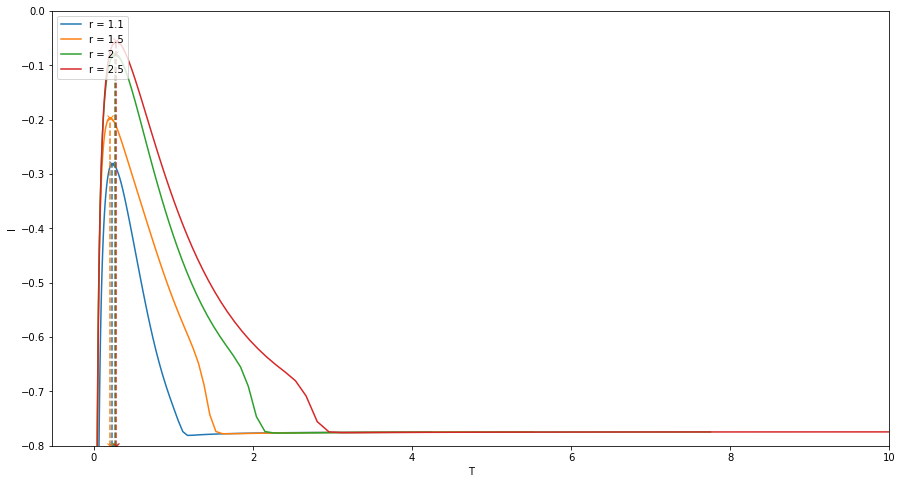

CPU times: user 5.93 s, sys: 133 ms, total: 6.06 s
Wall time: 7.73 s


In [322]:
%%time

var_1 = 1
var_2 = 1
v = np.array([1, 1])
n_samples = 100

plt.figure(figsize=(15,8))
for r in [1.1,1.5,2,2.5]:
    
    print("\nr = {}".format(r))    
   
    data, labels = generate_data(var_1, var_2, r, v, n_samples, False)
    centers = np.array([[0, 0], [r, r]])

    X_1 = np.transpose(data[:,:int(n_samples/2)]) 
    X_2 = np.transpose(data[:,int(n_samples/2):])
    labels_1 = labels[:int(n_samples/2)]
    labels_2 = labels[int(n_samples/2):]
    
    DAC_1 = DeterministicAnnealingClustering(n_clusters=2, random_state=42, record = True)
    DAC_1.fit(X_1)
    labels_DAC_1 = DAC_1.predict(X_1)
    
    DAC_2 = DeterministicAnnealingClustering(n_clusters=2, random_state=42, record = True)
    DAC_2.fit(X_2)
    labels_DAC_2 = DAC_2.predict(X_2)    

    num_temperatures_1 = len(DAC_1.cluster_history)
    num_temperatures_2 = len(DAC_2.cluster_history)
    num_temperatures = np.minimum(num_temperatures_1,num_temperatures_2)
    
    mi_history = np.zeros(num_temperatures)
    temp_history = np.zeros(num_temperatures)
    
    for k in range(num_temperatures):
        
        centers_1 = np.transpose(np.vstack(DAC_1.cluster_history[k]))
        centers_2 = np.transpose(np.vstack(DAC_2.cluster_history[k]))
        temp = DAC_1.temperatures[k]
    
        mi = mutual_information(np.transpose(X_1), np.transpose(X_2), np.transpose(centers_1), np.transpose(centers_2), temp)
        
        if np.isnan(mi):
            mi = -100
        mi_history[k] = mi
        temp_history[k] = temp
    
    mi_history = mi_history[2:-10]
    temp_history = temp_history[2:-10]
    
    mi_max_ind = np.argmax(mi_history)
    mi_max = mi_history[mi_max_ind]
    temp_max = temp_history[mi_max_ind]
    
    print("mi_max = {}".format(mi_max))
    print("temp_max = {}".format(temp_max))
    pp = plt.plot(temp_history,mi_history,label="r = {}".format(r))
    plt.plot([temp_max,temp_max],[-0.8,mi_max],color=pp[0].get_color(),linestyle='--',marker="x")

    mat_1 = metrics.confusion_matrix(labels_1, postprocess(labels_DAC_1, labels_1))
    mat_2 = metrics.confusion_matrix(labels_2, postprocess(labels_DAC_2, labels_2))    
    print("Confusion matrices: ")
    print(mat_1)
    print(mat_2)

plt.ylim(bottom=-0.8,top=0.0) 
plt.xlim(right=10.0) 
plt.xlabel("T")
plt.ylabel("I")
plt.legend(loc='upper right')
plt.show()    


<p style="background-color:#adebad;">
Now we plot of the maximum MI vs. the distance $r$.
</p>

/Users/cbamann/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in log2
/Users/cbamann/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars


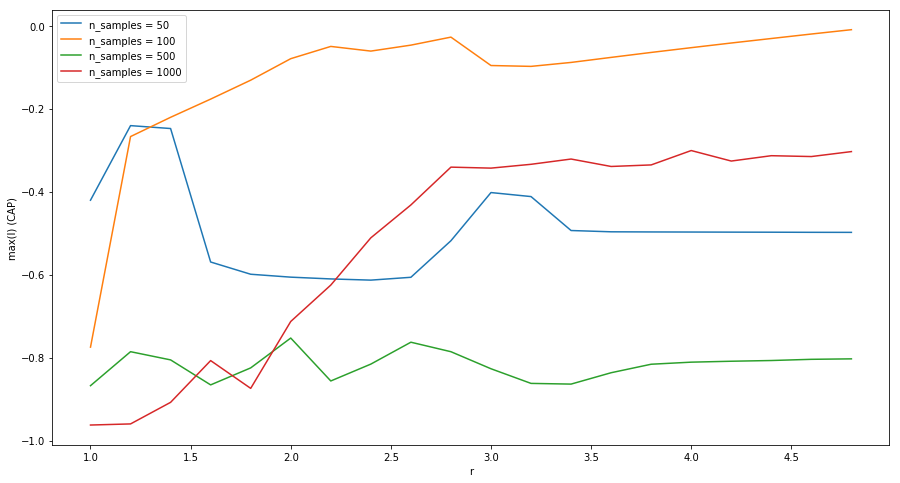

In [326]:
var_1 = 1
var_2 = 1
v = np.array([1, 1])
n_samples = 1000

plt.figure(figsize=(15,8))
#for r in [1.1,1.5,2,2.5]:

for n_samples in [50,100,500,1000]:

    mi_max_list = list()
    r_list = np.arange(1,5,0.2)
    
    for r in r_list:

        data, labels = generate_data(var_1, var_2, r, v, n_samples, False)
        centers = np.array([[0, 0], [r, r]])

        X_1 = np.transpose(data[:,:int(n_samples/2)])
        X_2 = np.transpose(data[:,int(n_samples/2):])
        labels_1 = labels[:int(n_samples/2)]
        labels_2 = labels[int(n_samples/2):]

        DAC_1 = DeterministicAnnealingClustering(n_clusters=2, random_state=42, record = True)
        DAC_1.fit(X_1)
        labels_DAC_1 = DAC_1.predict(X_1)

        DAC_2 = DeterministicAnnealingClustering(n_clusters=2, random_state=42, record = True)
        DAC_2.fit(X_2)
        labels_DAC_2 = DAC_2.predict(X_2)    

        num_temperatures_1 = len(DAC_1.cluster_history)
        num_temperatures_2 = len(DAC_2.cluster_history)
        num_temperatures = np.minimum(num_temperatures_1,num_temperatures_2)

        mi_history = np.zeros(num_temperatures)
        temp_history = np.zeros(num_temperatures)

        for k in range(num_temperatures):

            centers_1 = np.transpose(np.vstack(DAC_1.cluster_history[k]))
            centers_2 = np.transpose(np.vstack(DAC_2.cluster_history[k]))
            temp = DAC_1.temperatures[k]

            mi = mutual_information(np.transpose(X_1), np.transpose(X_2), np.transpose(centers_1), np.transpose(centers_2), temp)

            if np.isnan(mi):
                mi = -100
            mi_history[k] = mi
            temp_history[k] = temp

        mi_history = mi_history[2:-10]
        temp_history = temp_history[2:-10]

        mi_max_ind = np.argmax(mi_history)
        mi_max = mi_history[mi_max_ind]
        temp_max = temp_history[mi_max_ind]

        mi_max_list.append(mi_max)

    plt.plot(r_list,mi_max_list,label="n_samples = {}".format(n_samples))
    
plt.xlabel("r")
plt.ylabel("max(I) (CAP)")
plt.legend(loc='upper left')
plt.show()    


<p style="background-color:#adebad;">
We analyze the behavior of the maximal MI as a function of the number of data samples $n$ and the data dimension $d$. To do so, we plot several curves MI vs. $r$ for different $n$ and $d$.
</p>

/Users/cbamann/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: divide by zero encountered in log2
/Users/cbamann/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars


-0.7742452026778915
-0.767892060851068
-0.7598795905185697
-0.7598465045572412
-0.7616722415105632
-0.7637145495373855
-0.7655136314306433
-0.764176840594831
-0.7440422288300523
-0.7614232429221102
-0.7652004124107926
-0.7668671962166207
-0.7681477352168966
-0.7692004196667154
-0.7685203332496817
-0.7665926708852969
-0.7742457303457885
-0.7741007905305933
-0.7721574737833612
-0.7714884638751194
-0.7697970404161878
-0.7677535214081809
-0.7672730829701218
-0.7674664098940923
-0.7742457319841504
-0.7742457434313431
-0.7739303477311009
-0.7731771385225347
-0.7718557608548586
-0.7705574137805539
-0.7702649137477113
-0.7703865776776863


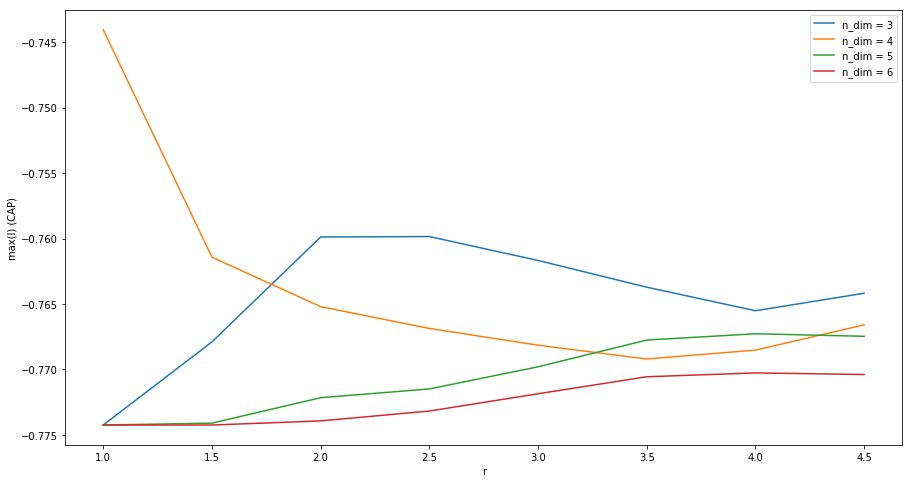

In [100]:
var_1 = 1
var_2 = 1
v = np.array([1, 1])
n_samples = 100

plt.figure(figsize=(15,8))
for n_dim in [3,4,5,6]:

    v = np.ones(n_dim)
    
    mi_max_list = list()
    r_list = np.arange(1,5,0.5)
    
    for r in r_list:

        data, labels = generate_data(var_1, var_2, r, v, n_samples, False)

        X_1 = np.transpose(data[:,:int(n_samples/2)])
        X_2 = np.transpose(data[:,int(n_samples/2):])
        labels_1 = labels[:int(n_samples/2)]
        labels_2 = labels[int(n_samples/2):]

        DAC_1 = DeterministicAnnealingClustering(n_clusters=2, random_state=42, record = True)
        DAC_1.fit(X_1)
        labels_DAC_1 = DAC_1.predict(X_1)        
           
        DAC_2 = DeterministicAnnealingClustering(n_clusters=2, random_state=42, record = True)
        DAC_2.fit(X_2)
        labels_DAC_2 = DAC_2.predict(X_2)    

        num_temperatures_1 = len(DAC_1.cluster_history)
        num_temperatures_2 = len(DAC_2.cluster_history)
        num_temperatures = np.minimum(num_temperatures_1,num_temperatures_2)

        mi_history = -1000*np.ones(num_temperatures)
        temp_history = np.zeros(num_temperatures)

        for k in range(num_temperatures):
            
            clusters_t_1 = DAC_1.cluster_history[k]

            if len(clusters_t_1) == 2:
            
                centers_1 = np.transpose(np.vstack(DAC_1.cluster_history[k]))
                centers_2 = np.transpose(np.vstack(DAC_2.cluster_history[k]))
                temp = DAC_1.temperatures[k]

                n_clusters = len(DAC_1.cluster_history[k])

                mi = mutual_information(np.transpose(X_1), np.transpose(X_2), np.transpose(centers_1), np.transpose(centers_2), temp)

                if np.isnan(mi):
                    mi = -100
                mi_history[k] = mi
                temp_history[k] = temp

        mi_history = mi_history[2:-10]
        temp_history = temp_history[2:-10]

        mi_max_ind = np.argmax(mi_history)
        mi_max = mi_history[mi_max_ind]
        temp_max = temp_history[mi_max_ind]
        
        print(mi_max)
        mi_max_list.append(mi_max)

    plt.plot(r_list,mi_max_list,label="n_dim = {}".format(n_dim))
    
plt.xlabel("r")
plt.ylabel("max(I) (CAP)")
plt.legend(loc='upper right')
plt.show()    
